In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure

In [2]:
base_path = '/kaggle/input/self-reported-qol/20230625-processed-'

df_physical      = pd.read_csv(base_path + 'physical-qol.csv')
df_psychological = pd.read_csv(base_path + 'psychological-qol.csv')

df_physical.drop('id', axis=1, inplace=True)         # id
df_physical.drop('day', axis=1, inplace=True)        # day
df_psychological.drop('id', axis=1, inplace=True)    # id
df_psychological.drop('day', axis=1, inplace=True)   # day

phy_all_tmp = df_physical.copy()
phy_init_set_tmp = phy_all_tmp.query("group in ('Initial Set')").copy()
phy_ufpi_ufc_tmp = phy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

psy_all_tmp = df_psychological.copy()
psy_init_set_tmp = psy_all_tmp.query("group in ('Initial Set')").copy()
psy_ufpi_ufc_tmp = psy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

phy_all_tmp.drop("group", axis=1, inplace=True)
phy_init_set_tmp.drop("group", axis=1, inplace=True)
phy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

psy_all_tmp.drop("group", axis=1, inplace=True)
psy_init_set_tmp.drop("group", axis=1, inplace=True)
psy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

# Separating predictors from the values to be predicted.
phy_all           = phy_all_tmp.drop("phy_ref_score", axis=1)
phy_all_pred      = phy_all_tmp["phy_ref_score"].copy()
phy_init_set      = phy_init_set_tmp.drop("phy_ref_score", axis=1)
phy_init_set_pred = phy_init_set_tmp["phy_ref_score"].copy()
phy_ufpi_ufc      = phy_ufpi_ufc_tmp.drop("phy_ref_score", axis=1)
phy_ufpi_ufc_pred = phy_ufpi_ufc_tmp["phy_ref_score"].copy()

psy_all           = psy_all_tmp.drop("psy_ref_score", axis=1)
psy_all_pred      = psy_all_tmp["psy_ref_score"].copy()
psy_init_set      = psy_init_set_tmp.drop("psy_ref_score", axis=1)
psy_init_set_pred = psy_init_set_tmp["psy_ref_score"].copy()
psy_ufpi_ufc      = psy_ufpi_ufc_tmp.drop("psy_ref_score", axis=1)
psy_ufpi_ufc_pred = psy_ufpi_ufc_tmp["psy_ref_score"].copy()

In [3]:
def plotKmeans2D_v2(df, columns, xy_labels, km):
    #extract the centres
    centres = pd.DataFrame(km.cluster_centers_, columns = ["x", "y"])
    #plot the results
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    hue_order = ['very-low', 'low', 'average', 'high', 'very-high']
    sns.scatterplot(data = df, x = columns[0], y = columns[1], hue = "cluster_label", hue_order=hue_order, palette = "tab10" )
    sns.scatterplot(data = centres, x = "x", y = "y", marker = "x", facecolor = "red", s = 200, label = "Centroids")
    ax.legend(fontsize = 20, title_fontsize = 20, title = "Labels", bbox_to_anchor = (1.02, 0.7), loc='upper left')
    ax.set_xlabel(xy_labels[0], fontsize = 20, labelpad = 20)
    ax.set_ylabel(xy_labels[1], fontsize = 20, labelpad = 20)

In [4]:
def plotKmeans2D(df, km, labels):
    df_as_np = np.array(df)

    #Getting the Centroids
    centroids = km.cluster_centers_
    u_labels = np.unique(labels)
    
    #plotting the results: 
    for i in u_labels:
        plt.scatter(df_as_np[labels == i , 0] , df_as_np[labels == i , 1], label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.show()

In [5]:
def runKmeans2D(df, columns, xy_labels, toPrint, inv):
    km = KMeans(n_clusters=5, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    label = km.fit_predict(df)

    df['cluster'] = label

    clusters = pd.DataFrame(km.cluster_centers_, columns=['x', 'y'])
    clusters['c_num'] = [0, 1, 2, 3, 4]
    clusters_sorted = clusters.sort_values(['x', 'y'], ascending = [True, True])

    if (inv): clusters_sorted['label'] = ['very-high', 'high', 'average', 'low', 'very-low']
    else: clusters_sorted['label'] = ['very-low', 'low', 'average', 'high', 'very-high']

    conditions = [
                  (df['cluster'] == clusters_sorted['c_num'].iloc[0]),
                  (df['cluster'] == clusters_sorted['c_num'].iloc[1]),
                  (df['cluster'] == clusters_sorted['c_num'].iloc[2]),
                  (df['cluster'] == clusters_sorted['c_num'].iloc[3]),
                  (df['cluster'] == clusters_sorted['c_num'].iloc[4]),
                 ]
    
    values = ['very-low', 'low', 'average', 'high', 'very-high']
    if (inv): values = ['very-high', 'high', 'average', 'low', 'very-low']
    
    df['cluster_label'] = np.select(conditions, values)

    if(toPrint):
      plotKmeans2D_v2(df, columns, xy_labels, km)
      #plotKmeans2D(df, km, label)

    return clusters_sorted

In [6]:
def remove_outliers(df, debug):
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_df = df[filtered_entries].copy()
    if(debug):
      print('Original shape:', df.shape, 'New shape:', new_df.shape)
      print(new_df.head())
    return new_df

# Daily Mobility

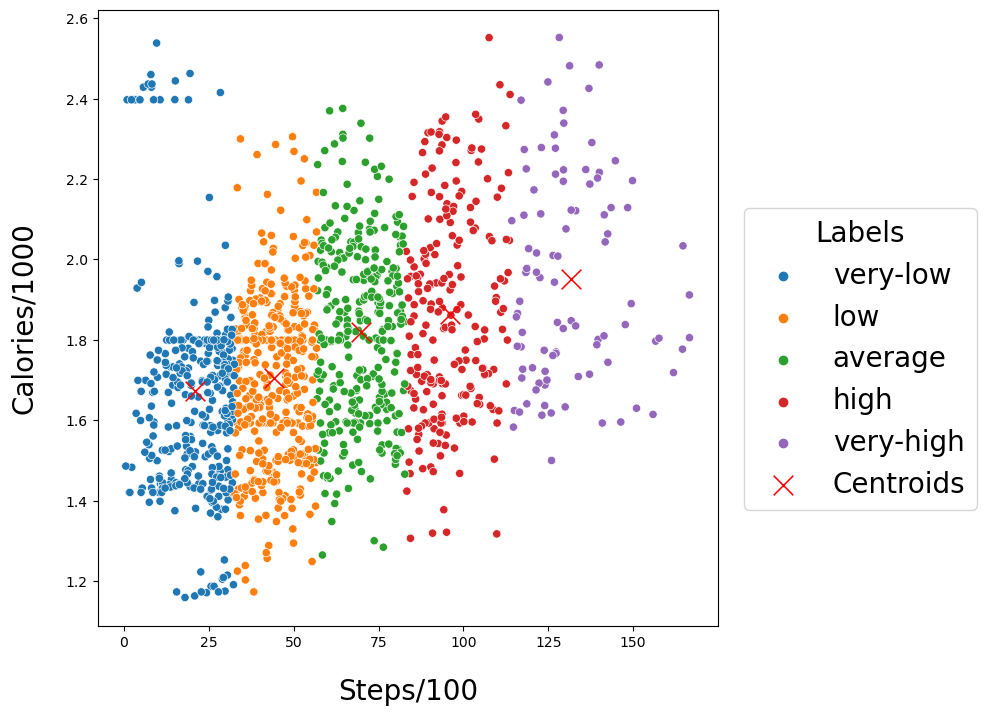

In [7]:
daily_mobility = df_physical[['steps', 'calories']].copy()

daily_mobility = daily_mobility.astype(float)
daily_mobility['steps'] = daily_mobility['steps']/100
daily_mobility['calories'] = daily_mobility['calories']/1000

new_df = remove_outliers(daily_mobility, False)

clusters_sorted = runKmeans2D(new_df, ['steps', 'calories'], ['Steps/100', 'Calories/1000'], True, False)

plt.savefig('daily-mobility-clusters.png', bbox_inches='tight')

# Physical Activity Level

In [8]:
phy_level = df_physical[['walking', 'running', 'biking', 'running(treadmill)', 'calories']].copy()
phy_level = phy_level.astype(float)

phy_level['act_time'] = phy_level['walking'] + (phy_level['running'] * 2) + (phy_level['biking'] * 2) + (phy_level['running(treadmill)'] * 2)
phy_level['act_time'] = phy_level['act_time']/60000
phy_level['calories'] = phy_level['calories']/10

phy_level.head()

,walking,running,biking,running(treadmill),calories,act_time
0,4063135.0,0.0,0.0,0.0,180.450,67.718917
1,48125.0,0.0,0.0,0.0,165.070,0.802083
2,4209154.0,0.0,0.0,0.0,186.860,70.152567
3,0.0,0.0,0.0,0.0,239.697,0.000000
4,4290043.0,0.0,0.0,0.0,175.803,71.500717


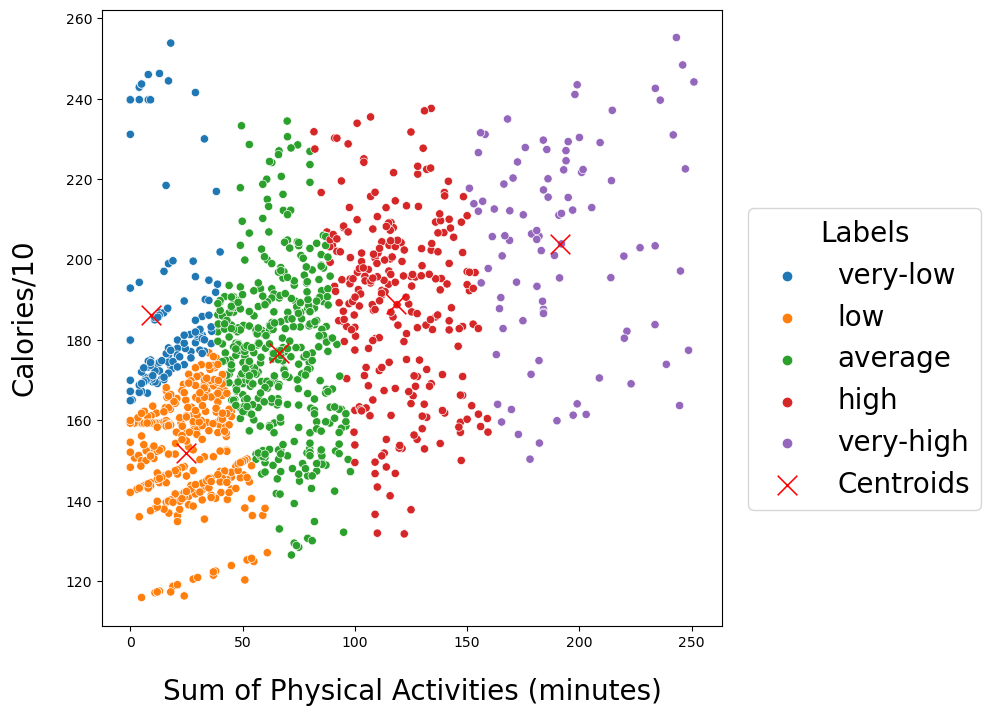

In [9]:
phy_clustering = phy_level[['act_time', 'calories']].copy()

new_df = remove_outliers(phy_clustering, False)

clusters_sorted = runKmeans2D(new_df, ['act_time', 'calories'], ['Sum of Physical Activities (minutes)', 'Calories/10'], True, False)

plt.savefig('phy-act-clusters.png', bbox_inches='tight')

# Social Mobility

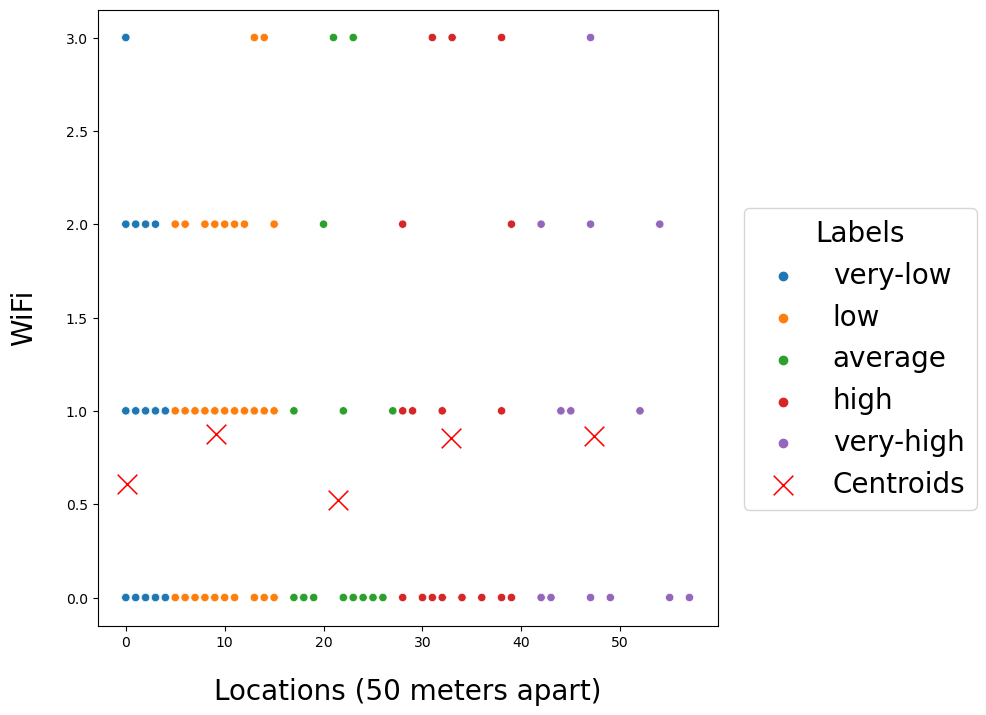

In [10]:
social_mobility = df_physical[['differentlocations', 'differentwifi']].copy()

social_mobility = social_mobility.astype(int)
social_mobility['differentlocations'] = social_mobility['differentlocations']
social_mobility['differentwifi'] = social_mobility['differentwifi']

new_df = remove_outliers(social_mobility, False)
clusters = runKmeans2D(new_df, ['differentlocations', 'differentwifi'], ['Locations (50 meters apart)', 'WiFi'], True, False)

plt.savefig('social-mobility-clusters.png', bbox_inches='tight')

# Loneliness

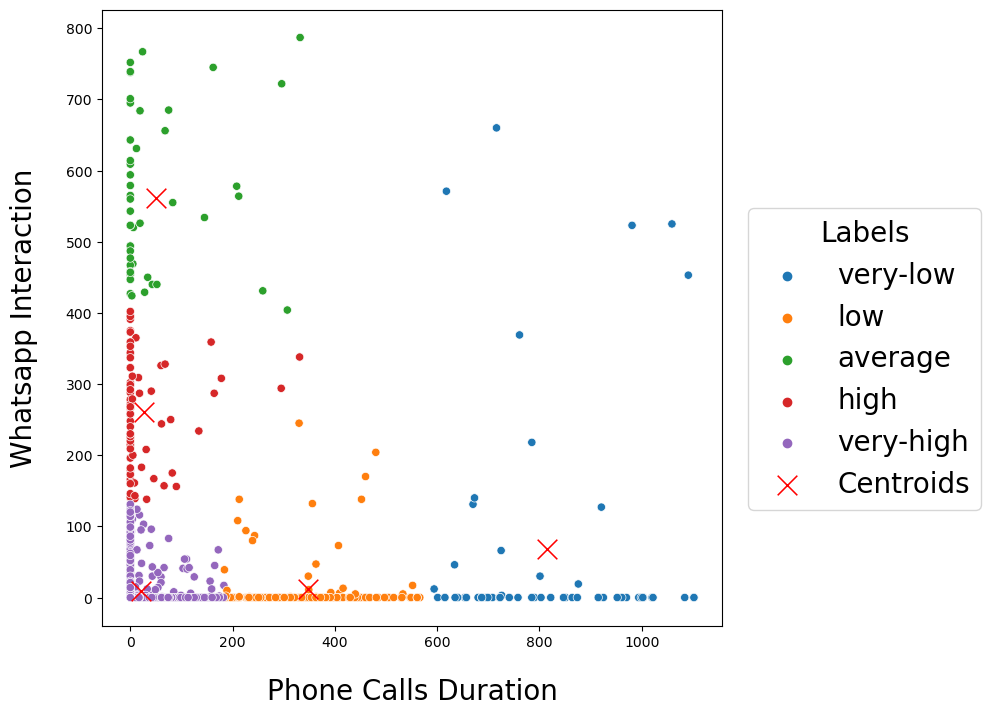

In [11]:
loneliness = df_physical[['incomingcalls', 'outgoingcalls', 'incomingcallsaverageduration', 'outgoingcallsaverageduration', 
                       'whatsappinvoice', 'whatsappinvideo', 'whatsappoutvoice', 'whatsappoutvideo', 'whatsappnotification']].copy()

loneliness = loneliness.astype(float)

loneliness['calls'] = (loneliness['incomingcalls'] * loneliness['incomingcallsaverageduration']) + (loneliness['outgoingcalls'] * loneliness['outgoingcallsaverageduration'])
loneliness['whatsapp'] = loneliness['whatsappinvoice'] + loneliness['whatsappinvideo'] + loneliness['whatsappoutvoice'] + loneliness['whatsappoutvideo'] + loneliness['whatsappnotification']

lone_clustering = loneliness[['calls', 'whatsapp']].copy()

new_df = remove_outliers(lone_clustering, False)

clusters_sorted = runKmeans2D(new_df, ['calls', 'whatsapp'], ['Phone Calls Duration', 'Whatsapp Interaction'], True, True)

plt.savefig('loneliness-clusters.png', bbox_inches='tight')